#### Agregamos las librerias y variables de control

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = 'lineas.mp4'

# Parametros para ajustar el poligono de la mascara
left_shift = 0     #  desviación izquierda de la línea de fuga
right_shift = 0    # desviación derecha de la línea de fuga
top_shift = -70      # Ajusta qué tan arriba empiezan las líneas de fuga
bottom_shift = 220  # Ajusta qué tan abajo empiezan las líneas de fuga

# Definimos el rango para el color amarillo
lower_yellow = np.array([15, 100, 100])  
upper_yellow = np.array([28, 255, 255])

# Definimos el rango para el color blanco
lower_white = np.array([0, 0, 200])  
upper_white = np.array([180, 20, 255])  

gamma = 3  # Valor de GAMMA

# vanishing_lines_mask  = None


#### Rellenado de la mascara
Agregamos nuestra primera función `fill_polygon`, que nos servirá para rellenar el polígono que definimos para la máscara. Esta función recibe como parámetros una máscara inicializada en ceros del mismo tamaño que la imagen, un arreglo de puntos y el color con el cual se va a colorear la máscara, en este caso, blanco puro `(255)`.

Funcionamiento:
- Encontramos los valores `minimos` y `maximos` en el eje `y`, ex: 0, 720
- Iteramos en el rango `y` que encontramos para rellenar un vector de intersecciones
- Recorremos la lista de puntos que hayamos definido para nuestro poligono
- Conectamos el ultimo punto con el primero con la operacion `(i + 1) % len(points)` esto da como resultado `0` cuando `k=n`, en pocas palabras cuando llega a su ultimo punto, se conecta con el primer punto como resultado de `modulo = 0`
- Verificamos si se forman parejas de puntos para formar una interseccion que sea horizontal, se agregan `(y_max-y_min)-2` parejas de puntos, dependiendo de del poligono
- Ordenamos de forma ascendente los pares de puntos que conforman una linea
- Por ultimo formamos las lineas entre dos puntos con la funcion de rango de numpy `y, x_start:x_end + 1`, esto significa que va tomar el mismo valor `y` pero va marcar cada pixel que este en el eje `x` desde `x_start` hasta `x_end` del color especificado, en este caso el color blanco puro `255`

In [24]:
def fill_polygon(mask, points, color=255):
    """
    Funcion para rellenar la mascara, marcar con un valor de 255 los pixeles que nos interesan con lineas
    """
    height, width = mask.shape[:2]  # Obtenemos el alto y ancho de la mascara

    points = np.array(points, dtype=np.int32)
    
    
    
    # Encontramos el límite de la caja que contiene el polígono
    x_min = max(0, np.min(points[:, 0]))
    x_max = min(width - 1, np.max(points[:, 0]))
    y_min = max(0, np.min(points[:, 1])) # Obtenemos el valor "y" Minimo para pintar el poligono
    y_max = min(height - 1, np.max(points[:, 1]))   # Obtenemos el valor maximo de "y" en los puntos
    
    # Iteramos en el rango que encontramos anteriormente para pintar el polígono
    for y in range(y_min, y_max + 1):
        # Encontrar los segmentos donde el polígono cruza una línea horizontal
        intersections = []
        # Iteramos la cantidad de puntos que hayamos definido en nuestro array
        for i in range(len(points)):
            x1, y1 = points[i]
            x2, y2 = points[(i + 1) % len(points)]  # Conecta el último punto con el primero cuando n/k = 0

            # Verificamos si los puntos forman una linea horizontal 
            if (y1 < y and y2 >= y) or (y2 < y and y1 >= y):
                # Encontrar la intersección con la línea horizontal
                x_intersection = x1 + (y - y1) * (x2 - x1) // (y2 - y1)
                # Agregamos la interseccion a la lista de intersecciones
                intersections.append(x_intersection)
        
        # Ordenamos las intersecciones de forma ascendente
        intersections.sort()
        
        # Dibujamos las lineas entre dos puntos de interseccion
        for i in range(0, len(intersections), 2):
            x_start = max(0, intersections[i])
            x_end = min(width - 1, intersections[i + 1])
            if x_start <= x_end:  # Verificamos que x_start no sea mayor que x_end
                mask[y, x_start:x_end + 1] = color  # Rellenar desde x_start hasta x_end con puntos 

#### Equalización del Histograma

La función `equalize_histogram` implementa la técnica de ecualización del histograma para mejorar el contraste cada frame. Distribuimos las intensidades de los pixeles para lograr un resultado mas uniforme, recibe como unico parametro el canal `V` de un frame `hsv`


In [25]:
def equalize_histogram(v_channel):
    # Paso 1: Calculamos el histograma de la imagen
    hist, _ = np.histogram(v_channel.flatten(), 256, [0, 256])

    # Paso 2: Calculamos la función de distribución acumulativa (CDF)
    cdf = hist.cumsum()
    
    # Normalizamos el CDF 
    cdf_normalized = cdf * (255.0 / cdf[-1])

    # Primero, buscamos que los valores sean enteros
    cdf_normalized = np.ma.masked_equal(cdf_normalized, 0)  # Ocultar valores 0
    cdf_normalized = (cdf_normalized - cdf_normalized.min()) * 255 / (cdf_normalized.max() - cdf_normalized.min())
    cdf_normalized = np.ma.filled(cdf_normalized, 0).astype('uint8')  # Rellenamod y convertimos a uint8

    # Paso 4: Aplicamos el remapeo a la imagen original usando la CDF
    equalized_v = cdf_normalized[v_channel]

    return equalized_v

#### Operador autocontraste

La función `autocontrast` implementa la técnica de autocontraste para normalizar el rango de contraste de cada frame para que ocupe el rango de `[0,255]`


In [26]:
def autocontrast(v_channel, alpha=0, beta=255):
    # Paso 1: Buscamos el valor mínimo y máximo del canal V
    v_min = np.min(v_channel)
    v_max = np.max(v_channel)
    
    # Eliminamos los valores que nos den 0
    if v_max - v_min == 0:
        return np.full(v_channel.shape, alpha, dtype=np.uint8)
    
    # Paso 2: Aplicamos la fomula del autocontraste
    v_normalized = ((v_channel - v_min) / (v_max - v_min)) * (beta - alpha) + alpha
    
    # Paso 3: Convertimos a uint8 
    v_normalized = np.clip(v_normalized, alpha, beta).astype(np.uint8)
    
    """ Documentacion de np.clip
    np.clip : Given an interval, values outside the interval are clipped to the interval edges. 
    For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, 
    and values larger than 1 become 1.
    """
    
    return v_normalized

#### Operador GAMMA

La función `_gamma` implementa el operador gamma para normalizar la iluminacion de cada frame, con esto logramos una mejor definicion en los bordes, recibe como parametros el canal `V` de un frame `hsv` y el valor `gamma`, entre mayo sea este valor la imagen se oscurecera mas 

In [27]:
def _gamma(v, gamma_val):
    # Paso 1: Dividimos cada valor de nuestro canal v por el valor de quantizacion
    normalized_v = v / 255.0
    # Paso 2: Elevamos al valor de gama
    corrected_v = np.power(normalized_v, gamma_val)
    # Paso 3: Multiplicamos por 255 para volver al rango de 0 a 255
    corrected_v = np.uint8(corrected_v * 255)    
    # Retornamos el valor con el operador gamma aplicado
    return corrected_v

#### Operador GAMMA

La función `create_color_mask` calcula la mascara de los colores de nuestro interes, recibe como parametros `lower_white`, `upper_white`, `lower_yellow`, `upper_yellow` y el canal `v` de nuestro frame, al final devuelve las dos mascaras para aplicarlas con un bitwise

In [28]:
def create_color_mask(lower_white, upper_white, lower_yellow, upper_yellow, hsv_corrected):
    # Creamos las máscaras usando operaciones numpy
    mask_yellow = np.all((hsv_corrected >= lower_yellow) & (hsv_corrected <= upper_yellow), axis=-1).astype(np.uint8) * 255
    mask_white = np.all((hsv_corrected >= lower_white) & (hsv_corrected <= upper_white), axis=-1).astype(np.uint8) * 255
    
    # Aclaramos el canal de valor (V) en las áreas donde las máscaras sean 255 (colores detectados)
    hsv_corrected[:, :, 2] = np.where(mask_yellow == 255, np.minimum(hsv_corrected[:, :, 2] + 255, 255), hsv_corrected[:, :, 2])
    hsv_corrected[:, :, 2] = np.where(mask_white == 255, np.minimum(hsv_corrected[:, :, 2] + 255, 255), hsv_corrected[:, :, 2])
    
    return mask_yellow, mask_white

#### Binarizacion
La funcion `binarize_frame` implementa la binarizacion utilizando la libreria numpy y sus operaciones vectorizadas para mejorar el rendimiento, al final devuelve la imagen binarizada `(blanco y negro)`

In [29]:
def binarize_frame(image, threshold_value, max_value):
    # Usar una operación vectorizada para optimizar la implementacion
    binary_image = np.where(image > threshold_value, max_value, 0).astype(np.uint8)
    return binary_image

#### Funcion para cargar el video para ejemplificar los resultados 

La funcion reutiliza el codigo para ejemplificar los resultados obtenidos con cada filtro aplicado

In [30]:
def load_video():
    # Abrimos el video 
    video = cv2.VideoCapture(video_path)

    # Obtenemos los fps del video para poder calcular la pausa del video
    fps = video.get(cv2.CAP_PROP_FPS)

    # Verificamos si el video se abrio correctamente
    if not video.isOpened():
        print("Error al abrir el video.")
        exit()
    # Obtenemos el primer frame de video para poder calcular el ancho y largo del mismo
    ret, frame = video.read()
    # Verificamos si pudimos obtener el primer frame 
    if not ret:
        print("No se pudo obtener el primer frame.")
        video.release()
        exit()    
    print("Video cargado satisfactoriamente")
    return video, frame, fps


#### Creamos la mascara para eliminar el contenido que no nos interesa

In [31]:
def create_vanishing_lines_mask():
    __, frame, _ = load_video()
    # Dimensiones del frame
    height, width = frame.shape[:2]

    # Creamos una máscara negra con las dimensiones del frame
    vanishing_lines_mask = np.zeros((height, width), dtype=np.uint8)

    # Definimos el poligono de nuestras las líneas de fuga 
    polygon_points = np.array([
        (left_shift, height - bottom_shift),
        (left_shift, height),
        (width - right_shift, height),
        (width - right_shift, height - bottom_shift),
        ((width // 12) * 7, height // 2 - top_shift),
        ((width // 12) * 5, height // 2 - top_shift)

    ], dtype=np.int32)

    # Dibujar el área de las líneas de fuga en la máscara
    fill_polygon(vanishing_lines_mask, polygon_points)

    print("Mascara creada satisfactoriamente")

    # fig, ax =  plt.subplots(1,1)
    # ax.imshow(vanishing_lines_mask, cmap="grey")
    # ax.set_title("Lineas de fuga")
    # plt.show()
    
    return vanishing_lines_mask
    

# create_vanishing_lines_mask()

##### Creamos una funcion para poder mostrar los histogramas acumulados despues de aplicar los operadores punto

In [32]:
def show_histogram(mod_accumulated_hist, original_accumulated_hist, operador):
    # Normalizamos el histograma acumulado modificado
    mod_hist_normalized = mod_accumulated_hist / mod_accumulated_hist.max()  # Normalizamos

    # Normalizamos el histograma acumulado original
    original_hist_normalized = original_accumulated_hist / original_accumulated_hist.max()  # Normalizamos

    # Mostramos los histogramas
    plt.figure(figsize=(12, 4))
    
    plt.plot(mod_hist_normalized, color='blue', label='Histograma Modificado')
    plt.plot(original_hist_normalized, color='orange', label='Histograma Original')
    
    plt.title(f"Histogramas Acumulados - {operador}")
    plt.xlim([0, 256])
    plt.xlabel("Intensidad de Pixel")
    plt.ylabel("Frecuencia Normalizada")
    plt.grid()
    plt.legend()
    plt.show()


### **PASO1:** Aplicar el operador autocontraste al canal `V`

Video cargado satisfactoriamente


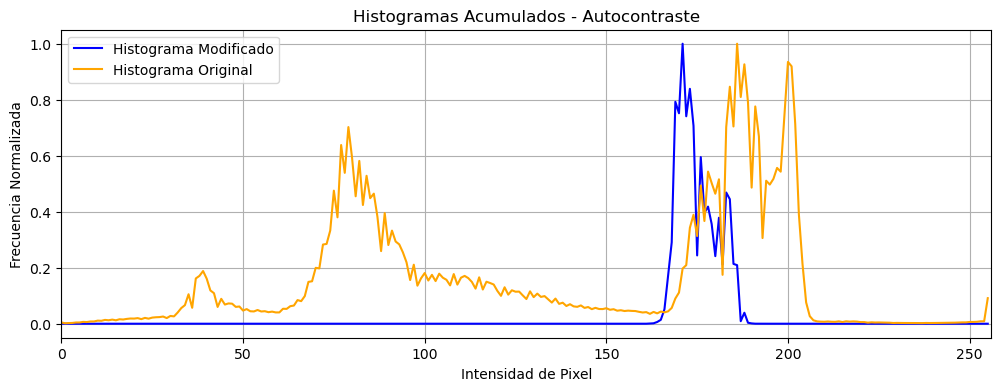

In [33]:
def show_autocontrast_working_video():
    video, frame, fps = load_video()
    mod_accumulated_hist = np.zeros(256)
    original_accumulated_hist = np.zeros(256)
    
    while True:

        ret, frame = video.read()

        # Verificar si se leyó correctamente
        if not ret:
            break
        # Convertimos el cuadro a otro espacio de color
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        v_autocontrast = autocontrast(hsv_frame[...,2])
        
        # Acumular el histograma del canal de brillo
        original_accumulated_hist += cv2.calcHist([hsv_frame[..., 2]], [0], None, [256], [0, 256]).flatten()
        mod_accumulated_hist += cv2.calcHist(v_autocontrast, [0], None, [256], [0, 256]).flatten()
        
        
        cv2.imshow('Video Procesado', v_autocontrast)
      
        # Capturar eventos de teclado
        key = cv2.waitKey(int(1000 / fps)) & 0xFF
        
        if key == ord('q'):  # Salir al presionar 'q'
            show_histogram(mod_accumulated_hist, original_accumulated_hist, "Autocontraste")
            break
    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

show_autocontrast_working_video()

### **PASO 2:** Aplicar ecualizacion del histograma al canal `V`

Video cargado satisfactoriamente


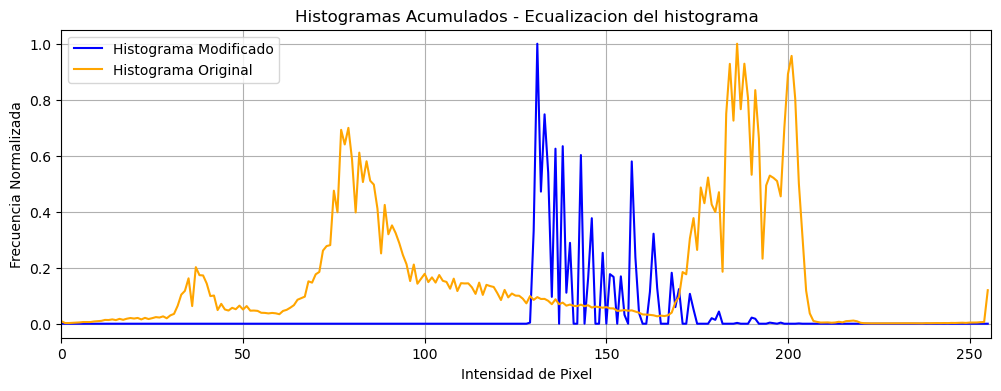

In [34]:
def show_hist_equalize_working_video():
    video, frame, fps = load_video()
    mod_accumulated_hist = np.zeros(256)
    original_accumulated_hist = np.zeros(256)
    
    while True:

        ret, frame = video.read()

        # Verificar si se leyó correctamente
        if not ret:
            break
        # Convertimos el cuadro a otro espacio de color
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Aplicamos autocontraste 
        v_autocontrast = autocontrast(hsv_frame[...,2])
        
        # Aplicamos ecualizacion del histograma
        v_equalized = equalize_histogram(v_autocontrast)
        
        # Acumular el histograma del canal de brillo
        original_accumulated_hist += cv2.calcHist([hsv_frame[..., 2]], [0], None, [256], [0, 256]).flatten()
        mod_accumulated_hist += cv2.calcHist(v_equalized, [0], None, [256], [0, 256]).flatten()
        
        
        cv2.imshow('Video Procesado', v_equalized)
      
        # Capturar eventos de teclado
        key = cv2.waitKey(int(1000 / fps)) & 0xFF
        
        if key == ord('q'):  # Salir al presionar 'q'
            show_histogram(mod_accumulated_hist, original_accumulated_hist, "Ecualizacion del histograma")
            break
    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

show_hist_equalize_working_video()

### **PASO 3:** Aplicar el operador GAMMA al canal `V`

Video cargado satisfactoriamente


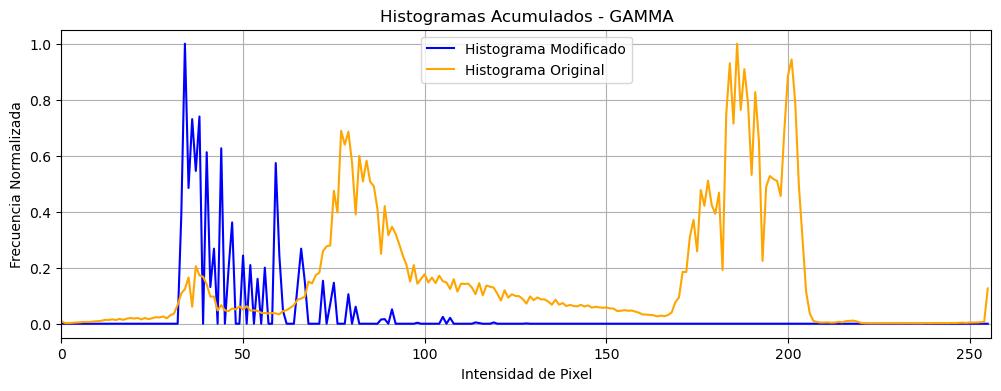

In [35]:
def show_gamma_working_video():
    video, frame, fps = load_video()
    mod_accumulated_hist = np.zeros(256)
    original_accumulated_hist = np.zeros(256)
    
    while True:

        ret, frame = video.read()

        # Verificar si se leyó correctamente
        if not ret:
            break
        # Convertimos el cuadro a otro espacio de color
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Aplicamos autocontraste 
        v_autocontrast = autocontrast(hsv_frame[...,2])
        
        # Aplicamos ecualizacion del histograma
        v_equalized = equalize_histogram(v_autocontrast)
        
        # Aplicamos el operador gamma     
        v_gamma_corrected = _gamma(v_equalized, gamma)
        
        # Acumular el histograma del canal de brillo
        original_accumulated_hist += cv2.calcHist([hsv_frame[..., 2]], [0], None, [256], [0, 256]).flatten()
        mod_accumulated_hist += cv2.calcHist(v_gamma_corrected, [0], None, [256], [0, 256]).flatten()
        
        
        cv2.imshow('Video Procesado', v_equalized)
      
        # Capturar eventos de teclado
        key = cv2.waitKey(int(1000 / fps)) & 0xFF
        
        if key == ord('q'):  # Salir al presionar 'q'
            show_histogram(mod_accumulated_hist, original_accumulated_hist, "GAMMA")
            break
    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

show_gamma_working_video()

### **PASO 4:** Aplicamos las mascaras de color para separar el contenido de interes del que no

Video cargado satisfactoriamente


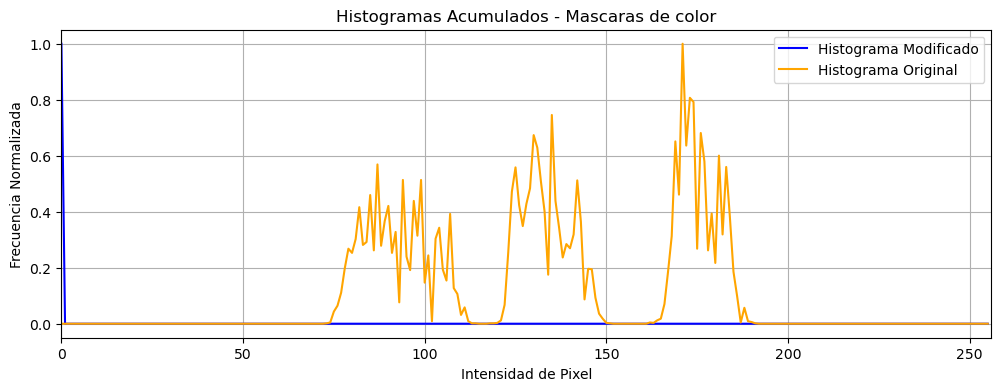

In [36]:
def show_mask_working_video():
    video, frame, fps = load_video()
    mod_accumulated_hist = np.zeros(256)
    original_accumulated_hist = np.zeros(256)
    
    while True:

        ret, frame = video.read()

        # Verificar si se leyó correctamente
        if not ret:
            break
        # Convertimos el cuadro a otro espacio de color
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Aplicamos autocontraste 
        v_autocontrast = autocontrast(hsv_frame[...,2])
        
        # Aplicamos ecualizacion del histograma
        v_equalized = equalize_histogram(v_autocontrast)
        
        # Aplicamos el operador gamma     
        v_gamma_corrected = _gamma(v_equalized, gamma)
        
        # Actualizar directamente el canal V en hsv_frame
        hsv_frame[..., 2] = v_gamma_corrected
        
        # Obtenemos el frame en BGR para testeos
        bgr_result = cv2.cvtColor(hsv_frame, cv2.COLOR_HSV2BGR)
        
        # Creamos las mascaras de color con los rangos definidosanteriormente
        mask_yellow, mask_white = create_color_mask(lower_white, upper_white, lower_yellow, upper_yellow, hsv_frame) 
           
        # Aplicar la máscara de color a la imagen original
        color_mask = cv2.bitwise_or(mask_yellow, mask_white)
        
        # Obtenemos el frame con los colores de las mascaras resaltados 
        two_mask_result = cv2.bitwise_and(bgr_result, bgr_result, mask=color_mask) 
        
        # Convertimos el frame a escala de grises para obtener la máscara de líneas de fuga
        result_gray = cv2.cvtColor(two_mask_result, cv2.COLOR_BGR2GRAY)
        
        # Acumular el histograma del canal de brillo
        original_accumulated_hist += cv2.calcHist(frame, [0], None, [256], [0, 256]).flatten()
        mod_accumulated_hist += cv2.calcHist(result_gray, [0], None, [256], [0, 256]).flatten()
        
        cv2.imshow('Video Procesado', result_gray)
      
        # Capturar eventos de teclado
        key = cv2.waitKey(int(1000 / fps)) & 0xFF
        
        if key == ord('q'):  # Salir al presionar 'q'
            show_histogram(mod_accumulated_hist, original_accumulated_hist, "Mascaras de color")
            break
    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

show_mask_working_video()

### **PASO 5:** Binarizamos la imagen y aplicamos la mascara de las lineas de fuga

`Importante:` Ver el ultimo segmento de codigo donde se muestran

Video cargado satisfactoriamente
Video cargado satisfactoriamente
Mascara creada satisfactoriamente


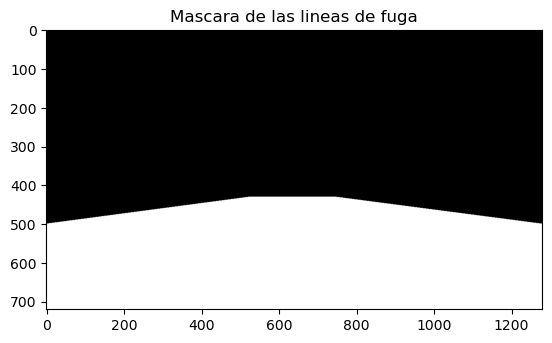

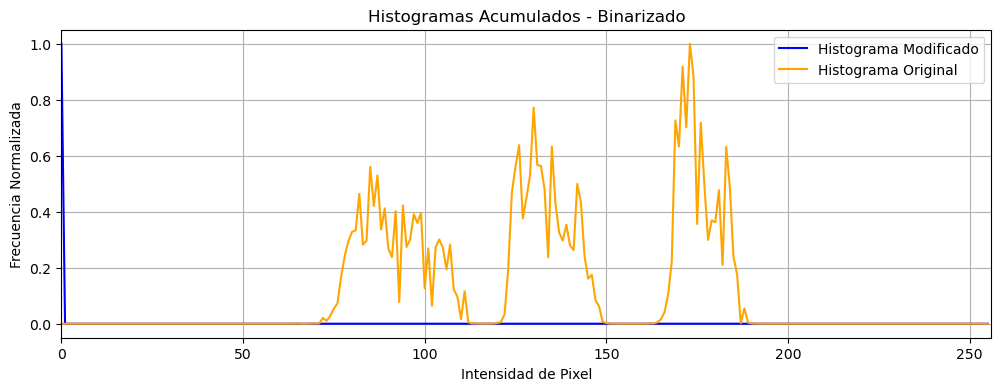

In [50]:

    
def show_binarized_working_video():
    video, frame, fps = load_video()
    mod_accumulated_hist = np.zeros(256)
    original_accumulated_hist = np.zeros(256)
    
    vanishing_mask = create_vanishing_lines_mask()
        
    
    fig, ax =  plt.subplots(1,1)
    ax.imshow(vanishing_mask, cmap="grey")
    ax.set_title("Mascara de las lineas de fuga")
    plt.show()
    
    while True:

        ret, frame = video.read()

        # Verificar si se leyó correctamente
        if not ret:
            break
        # Convertimos el cuadro a otro espacio de color
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Aplicamos autocontraste 
        v_autocontrast = autocontrast(hsv_frame[...,2])
        
        # Aplicamos ecualizacion del histograma
        v_equalized = equalize_histogram(v_autocontrast)
        
        # Aplicamos el operador gamma     
        v_gamma_corrected = _gamma(v_equalized, gamma)
        
        # Actualizar directamente el canal V en hsv_frame
        hsv_frame[..., 2] = v_gamma_corrected
        
        # Obtenemos el frame en BGR para testeos
        bgr_result = cv2.cvtColor(hsv_frame, cv2.COLOR_HSV2BGR)
        
        # Creamos las mascaras de color con los rangos definidosanteriormente
        mask_yellow, mask_white = create_color_mask(lower_white, upper_white, lower_yellow, upper_yellow, hsv_frame) 
           
        # Aplicar la máscara de color a la imagen original
        color_mask = cv2.bitwise_or(mask_yellow, mask_white)
        
        # Obtenemos el frame con los colores de las mascaras resaltados 
        two_mask_result = cv2.bitwise_and(bgr_result, bgr_result, mask=color_mask) 
        
        # Convertimos el frame a escala de grises para obtener la máscara de líneas de fuga
        result_gray = cv2.cvtColor(two_mask_result, cv2.COLOR_BGR2GRAY)
        
        frame_binary = binarize_frame(result_gray, 0, 255)
        # frame_binary = binarize_frame(result_gray, binarization_threshold, 255)
        
        # Aplicamos la mascara que contiene nuestras lineas de fuga al frame
        masked_frame = cv2.bitwise_and(frame_binary, frame_binary, mask=vanishing_mask)
        
        # Acumular el histograma del canal de brillo
        original_accumulated_hist += cv2.calcHist(frame, [0], None, [256], [0, 256]).flatten()
        mod_accumulated_hist += cv2.calcHist(masked_frame, [0], None, [256], [0, 256]).flatten()
        
        cv2.imshow('Video Procesado', masked_frame)

        # Capturar eventos de teclado
        key = cv2.waitKey(int(1000 / fps)) & 0xFF
        
        if key == ord('q'):  # Salir al presionar 'q'
            show_histogram(mod_accumulated_hist, original_accumulated_hist, "Binarizado")
            break
    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

    
show_binarized_working_video()

### **Mostrar los resultados obtenenidos**

Video cargado satisfactoriamente
Video cargado satisfactoriamente
Mascara creada satisfactoriamente
Video info: 1260 - 25.0
Calculando frames: 0 
Calculando frames: 141 
Calculando frames: 282 
Calculando frames: 423 
Calculando frames: 564 
Calculando frames: 705 
Calculando frames: 846 
Calculando frames: 987 
Calculando frames: 1128 


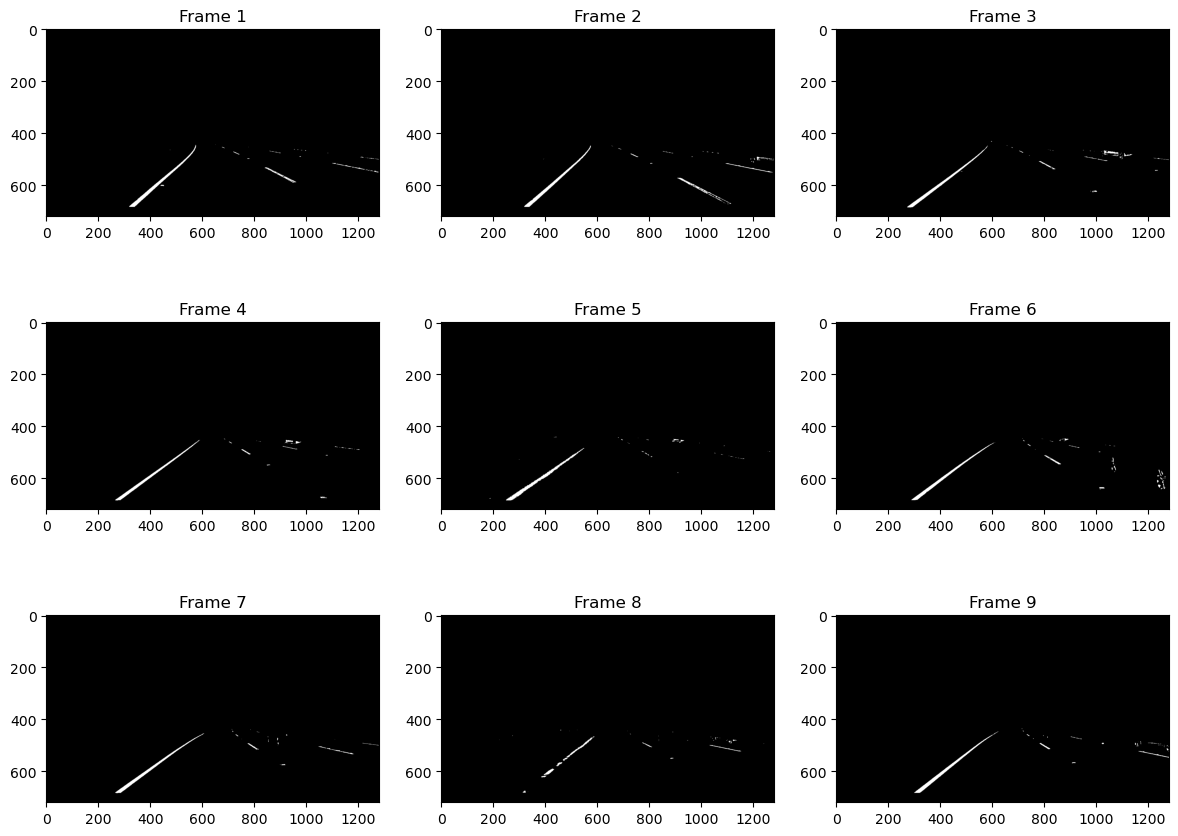

In [49]:
def get_vid_additional_info(video_path):
    """
    Obtiene información adicional de un video, incluyendo el número total de fotogramas y los fotogramas por segundo (FPS).

    """
    # Cargamos el video
    video = cv2.VideoCapture(video_path)

    # Verificamos si el video se abrió correctamente
    if not video.isOpened():
        print("Error al abrir el video")
        return None

    # Obtenemos el número de fotogramas por segundo (FPS)
    fps = video.get(cv2.CAP_PROP_FPS)

    # Calculamos el número total de fotogramas
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Liberamos el video para utilizarlo después
    video.release()

    return frame_count, fps

def show_last_frames(frames):
    """
    Muestra los últimos 9 fotogramas en una cuadrícula de 3x3 utilizando Matplotlib.

    """
    fig, ax = plt.subplots(3, 3, figsize=(12, 9))

    # Asegúrate de que frames tenga al menos 9 elementos
    if len(frames) < 9:
        print("No hay suficientes frames para mostrar.")
        return

    for i in range(3):
        for j in range(3):
            index = i * 3 + j  # Calcular el índice del frame
            ax[i, j].imshow(frames[index], cmap="gray")  # Usar 'gray' para imágenes en escala de grises
            ax[i, j].set_title(f"Frame {index + 1}")  # Título del frame

    plt.tight_layout()  # Mejora la presentación
    plt.show()      

def show_binarized_working_video():

    video, frame, fps = load_video()

    vanishing_mask = create_vanishing_lines_mask()
        
    number_frames, fps = get_vid_additional_info(video_path)
    
    print(f"Video info: {number_frames} - {fps}")
    
    frame_count = 0
    skip_frames = number_frames / 9
    
    frames = []
    while True:

        ret, frame = video.read()

        # Verificar si se leyó correctamente
        if not ret:
            break
        
        if frame_count % (skip_frames + 1) == 0:
            # Convertimos el cuadro a otro espacio de color
            hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Aplicamos autocontraste 
            v_autocontrast = autocontrast(hsv_frame[..., 2])
            
            # Aplicamos ecualización del histograma
            v_equalized = equalize_histogram(v_autocontrast)
            
            # Aplicamos el operador gamma     
            v_gamma_corrected = _gamma(v_equalized, gamma)
            
            # Actualizar directamente el canal V en hsv_frame
            hsv_frame[..., 2] = v_gamma_corrected
            
            # Obtenemos el frame en BGR para testear
            bgr_result = cv2.cvtColor(hsv_frame, cv2.COLOR_HSV2BGR)
            
            # Creamos las máscaras de color con los rangos definidos anteriormente
            mask_yellow, mask_white = create_color_mask(lower_white, upper_white, lower_yellow, upper_yellow, hsv_frame) 
            
            # Aplicar la máscara de color a la imagen original
            color_mask = cv2.bitwise_or(mask_yellow, mask_white)
            
            # Obtenemos el frame con los colores de las máscaras resaltados 
            two_mask_result = cv2.bitwise_and(bgr_result, bgr_result, mask=color_mask) 
            
            # Convertimos el frame a escala de grises para obtener la máscara de líneas de fuga
            result_gray = cv2.cvtColor(two_mask_result, cv2.COLOR_BGR2GRAY)
            
            frame_binary = binarize_frame(result_gray, 0, 255)

            # Aplicamos la máscara que contiene nuestras líneas de fuga al frame
            masked_frame = cv2.bitwise_and(frame_binary, frame_binary, mask=vanishing_mask)
            
            frames.append(masked_frame)
            
            print(f"Calculando frames: {frame_count} ")
            
        frame_count += 1
    
    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

    show_last_frames(frames)
    
# Ejemplo de uso
show_binarized_working_video()